## Homework 1: Futures Spread Dynamic
#### NAME: Arturo Charleston
#### Student ID: 12449584

In [1]:
# PACKAGES
import os
import datetime
import quandl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set directory
home_directory = "/Users/charleston/Downloads/git_repositories/finm-qts-2025"
os.chdir(home_directory)

# Set keys
from config import PRIVATE_KEY
quandl_keys = PRIVATE_KEY


In [2]:
# FUNCTIONS

def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(home_directory, "data", "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=q, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

## Data Cleaning

In [3]:
# Download data
t_ivm = fetch_quandl_table('AR/IVM', avoid_download=False)

Data file /Users/charleston/Downloads/git_repositories/finm-qts-2025/data/quandl_data_table_downloads/AR/IVM_20250112.zip size 323695782 exists already, no need to download


In [4]:
t_ivm.shape

(5352205, 21)

In [5]:
t_ivm.head()

,exchange_code,futures_code,option_code,expiration,date,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
0,CBT,BO,BO,1M,2024-12-16,41.731864,0.302640,0.017717,0.028022,0.008861,...,0.136273,2.253584,-4.503889,-12.900171,33.798866,123.711572,-0.208212,0.237649,31.0,31.0
1,CBT,BO,BO,1W,2024-12-16,41.589492,0.275612,-0.009755,-0.026915,0.008703,...,-0.184783,12.724505,-9.970579,-380.836794,172.546492,3543.441557,-0.105488,0.089992,7.0,7.0
2,CBT,BO,BO,1Y,2024-12-16,42.360909,0.280757,0.027657,0.056929,0.003687,...,0.080256,-0.029207,-0.342699,1.571995,0.678517,-3.644149,-0.521268,0.535857,365.0,365.0
3,CBT,BO,BO,2M,2024-12-16,41.915763,0.329431,0.043624,0.072584,0.009547,...,0.234473,0.732446,-3.166721,3.916127,14.579110,-26.639620,-0.291922,0.406860,62.0,62.0
4,CBT,BO,BO,3M,2024-12-16,42.079836,0.331620,0.046527,0.078083,0.009520,...,0.207442,0.439917,-1.951898,2.573566,6.612833,-11.690214,-0.344729,0.488955,90.0,90.0


In [6]:
# Clean the data
# Filter the main dataset by date
t_ivm_filtered = t_ivm[(t_ivm['date'] > '2021-12-03') & (t_ivm['date'] < '2024-08-31')]

# Define the datasets
datasets = {
    "CBT_FV": t_ivm_filtered.query('exchange_code == "CBT" and futures_code == "FV"'),
    "CBT_TY": t_ivm_filtered.query('exchange_code == "CBT" and futures_code == "TY"'),
    "NYM_RB": t_ivm_filtered.query('exchange_code == "NYM" and futures_code == "RB"'),
    "ICE_G": t_ivm_filtered.query('exchange_code == "ICE" and futures_code == "G"'),
}

# Apply filtering logic with an anonymous function
datasets_filtered = {key: (lambda df: df.loc[df[df['days_termination'] > 30]
                                .groupby('date')['days_termination'].idxmin()])(df) 
                     for key, df in datasets.items()}

# Compute the CBT_FV_CBT_TY spread
CBT_FV_CBT_TY = (
    datasets_filtered["CBT_TY"].set_index('date')['futures'] * 0.9524 - 
    datasets_filtered["CBT_FV"].set_index('date')['futures']
)

# Compute the NYM_RB_ICE_G spread
NYM_RB_ICE_G = (
    datasets_filtered["ICE_G"].set_index('date')['futures'] * 0.0033 - 
    datasets_filtered["NYM_RB"].set_index('date')['futures']
)

In [7]:
# Sanity check to confirm that the data is correct
import pandas.testing as pd_testing

# Define expected values for sanity check from the HW pdf
expected_values_NYM_RB_ICE_G = {
    '2024-03-28': -0.043981,
    '2024-04-01': 0.002725
}

expected_values_CBT_FV_CBT_TY = {
    '2024-02-16': -1.989725,
    '2024-02-19': -1.822434
}

# Sanity checks for NYM_RB_ICE_G
for date, value in expected_values_NYM_RB_ICE_G.items():
    pd_testing.assert_series_equal(pd.Series([NYM_RB_ICE_G.get(date)], index=[date]), pd.Series([value], index=[date]), atol=1e-5)

# Sanity checks for CBT_FV_CBT_TY
for date, value in expected_values_CBT_FV_CBT_TY.items():
    pd_testing.assert_series_equal(pd.Series([CBT_FV_CBT_TY.get(date)], index=[date]), pd.Series([value], index=[date]), atol=1e-5)

print("Sanity checks passed successfully.")

Sanity checks passed successfully.


## Analysis of the futures spread

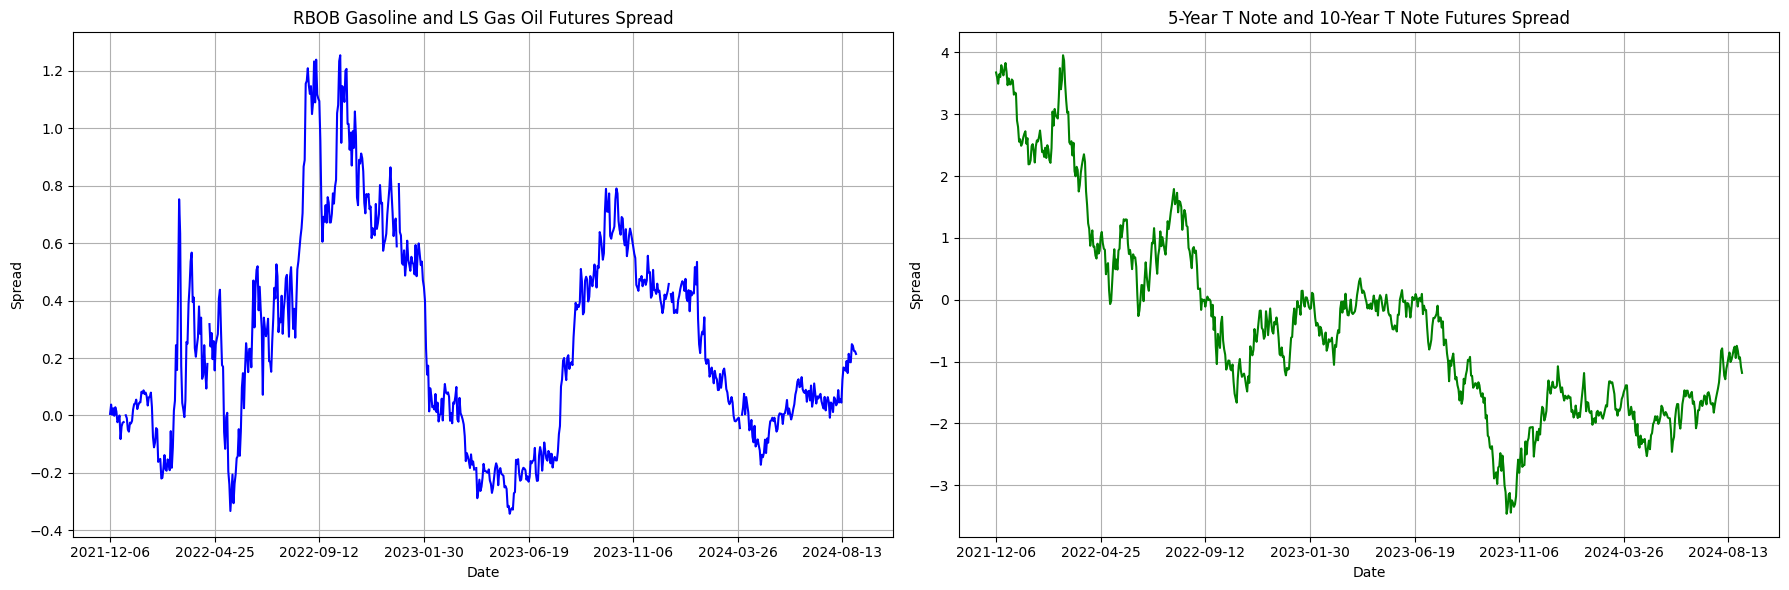

In [8]:
# LABELS
NYM_RB_ICE_G.name = 'RBOB Gasoline and LS Gas Oil Futures Spread'
CBT_FV_CBT_TY.name = '5-Year T Note and 10-Year T Note Futures Spread'

# Plot of the time series
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

NYM_RB_ICE_G.plot(ax=axes[0], title=NYM_RB_ICE_G.name, color='blue')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Spread')
axes[0].grid(True)

CBT_FV_CBT_TY.plot(ax=axes[1], title=CBT_FV_CBT_TY.name, color='green')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Spread')
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [9]:
# Summary stats for both spreads including skewness and kurtosis
summary_stats = pd.DataFrame({
    NYM_RB_ICE_G.name: NYM_RB_ICE_G.describe(),
    CBT_FV_CBT_TY.name: CBT_FV_CBT_TY.describe()
})

summary_stats.loc['skewness'] = [NYM_RB_ICE_G.skew(), CBT_FV_CBT_TY.skew()]
summary_stats.loc['kurtosis'] = [NYM_RB_ICE_G.kurt(), CBT_FV_CBT_TY.kurt()]

summary_stats.T

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
RBOB Gasoline and LS Gas Oil Futures Spread,708.0,0.246494,0.350763,-0.342450,-0.011164,0.162842,0.483589,1.254567,0.637377,-0.217298
5-Year T Note and 10-Year T Note Futures Spread,714.0,-0.375307,1.589357,-3.463422,-1.584706,-0.578132,0.369889,3.955143,0.761679,0.085455


In [10]:
# Create rolling window difference data
df = pd.DataFrame({
    'NYM_RB_ICE_G': NYM_RB_ICE_G,
    'CBT_FV_CBT_TY': CBT_FV_CBT_TY
}).set_index(NYM_RB_ICE_G.index)

# Ensure the 'date' index is in datetime format
df.index = pd.to_datetime(df.index)

# Rolling window sizes for analysis
# one week, two weeks, one month, two months
windows = [5, 10, 30, 60]

# Compute rolling means and differences for each window
for window in windows:
    df[f'NYM_RB_ICE_G_{window}_rolling'] = df['NYM_RB_ICE_G'].rolling(window).mean()
    df[f'CBT_FV_CBT_TY_{window}_rolling'] = df['CBT_FV_CBT_TY'].rolling(window).mean()
    df[f'diff_NYM_RB_ICE_G_{window}'] = df['NYM_RB_ICE_G'] - df[f'NYM_RB_ICE_G_{window}_rolling']
    df[f'diff_CBT_FV_CBT_TY_{window}'] = df['CBT_FV_CBT_TY'] - df[f'CBT_FV_CBT_TY_{window}_rolling']


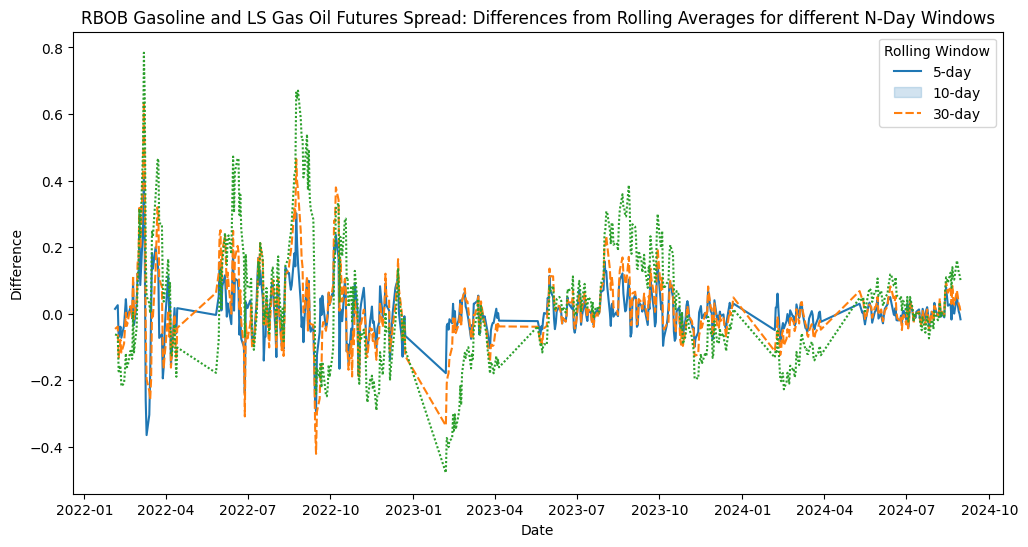

In [11]:
# Plot the rolling differences for visualization
plt.figure(figsize=(12, 6))

sns.lineplot(data=df[['diff_NYM_RB_ICE_G_5', 'diff_NYM_RB_ICE_G_10', 'diff_NYM_RB_ICE_G_30']].dropna())
plt.title(f"{NYM_RB_ICE_G.name}: Differences from Rolling Averages for different N-Day Windows")
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend(['5-day', '10-day', '30-day'], title='Rolling Window')
plt.show()

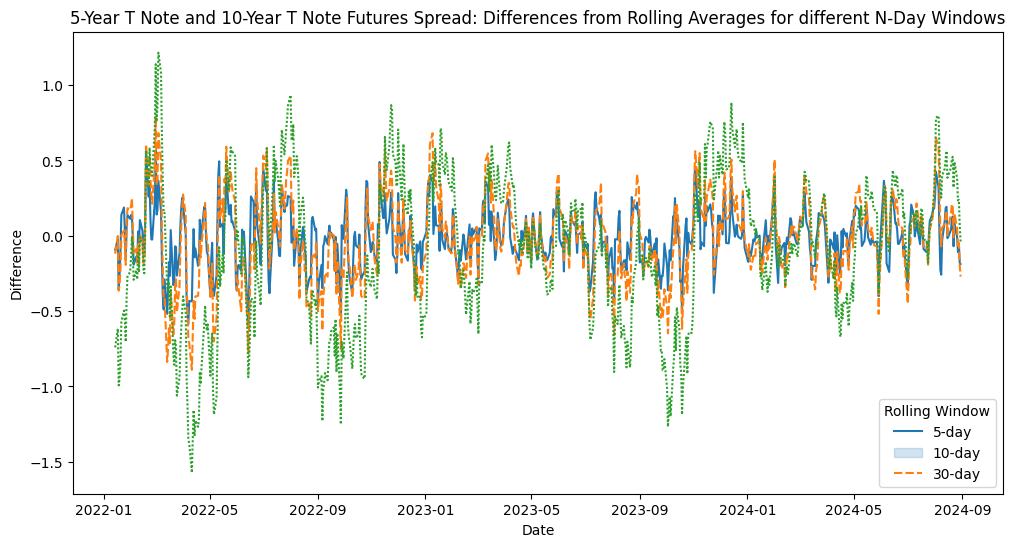

In [12]:
# Repeat for CBT_FV_CBT_TY
plt.figure(figsize=(12, 6))
sns.lineplot(data=df[['diff_CBT_FV_CBT_TY_5', 'diff_CBT_FV_CBT_TY_10', 'diff_CBT_FV_CBT_TY_30']].dropna())
plt.title(f"{CBT_FV_CBT_TY.name}: Differences from Rolling Averages for different N-Day Windows")
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend(['5-day', '10-day', '30-day'], title='Rolling Window')
plt.show()

In [13]:
# Summary statistics for each spread's rolling difference
rolling_diff_stats_NYM_RB_ICE_G = {}
rolling_diff_stats_CBT_FV_CBT_TY = {}

for window in windows:
    rolling_diff_stats_NYM_RB_ICE_G[window] = df[f'diff_NYM_RB_ICE_G_{window}'].describe()
    rolling_diff_stats_CBT_FV_CBT_TY[window] = df[f'diff_CBT_FV_CBT_TY_{window}'].describe()


In [14]:
print(f"{NYM_RB_ICE_G.name}: Difference from Rolling Averages for Different Windows Summary Statistics")
pd.DataFrame(rolling_diff_stats_NYM_RB_ICE_G).T

RBOB Gasoline and LS Gas Oil Futures Spread: Difference from Rolling Averages for Different Windows Summary Statistics


,count,mean,std,min,25%,50%,75%,max
5,680.0,0.000629,0.073212,-0.364347,-0.033750,0.001000,0.031718,0.424161
10,645.0,0.002229,0.107890,-0.420690,-0.044609,-0.003811,0.043670,0.640783
30,520.0,0.027295,0.182945,-0.477340,-0.104318,0.010879,0.118412,0.784156
60,340.0,0.112963,0.240639,-0.366701,-0.056265,0.090588,0.301661,0.782819


In [15]:
print(f"{CBT_FV_CBT_TY.name}:  Difference from Rolling Averages for Different Windows Summary Statistics")
pd.DataFrame(rolling_diff_stats_CBT_FV_CBT_TY).T

5-Year T Note and 10-Year T Note Futures Spread:  Difference from Rolling Averages for Different Windows Summary Statistics


,count,mean,std,min,25%,50%,75%,max
5,710.0,-0.013170,0.184156,-0.607200,-0.124802,-0.013117,0.104251,0.565353
10,705.0,-0.029668,0.275627,-0.889600,-0.208690,-0.028525,0.150719,0.794609
30,685.0,-0.086170,0.491817,-1.572438,-0.414147,-0.054166,0.292785,1.215300
60,655.0,-0.175794,0.657748,-2.033751,-0.576527,-0.063845,0.287119,1.284232


In [16]:
# Calculate rolling differences for both datasets with window of 10 for a finer look
df['diff_NYM_RB_ICE_G_10'] = df['NYM_RB_ICE_G'] - df['NYM_RB_ICE_G_10_rolling']
df['diff_CBT_FV_CBT_TY_10'] = df['CBT_FV_CBT_TY'] - df['CBT_FV_CBT_TY_10_rolling']

# Correlation between the difference time series
corr = df[['diff_NYM_RB_ICE_G_10', 'diff_CBT_FV_CBT_TY_10']].dropna().corr()
corr

,diff_NYM_RB_ICE_G_10,diff_CBT_FV_CBT_TY_10
diff_NYM_RB_ICE_G_10,1.000000,-0.052827
diff_CBT_FV_CBT_TY_10,-0.052827,1.000000


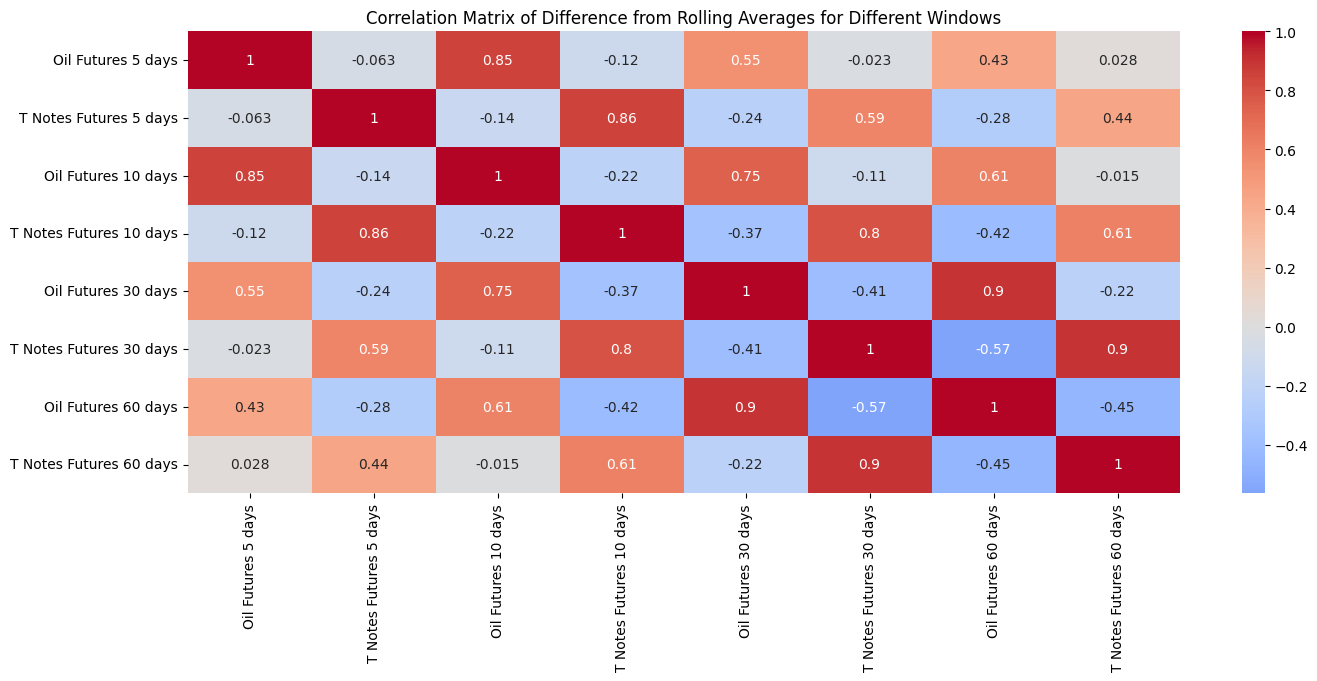

In [17]:
# Calculate correlation matrix for all rolling differences
rolling_diff_columns = [col for col in df.columns if 'diff' in col]
corr_matrix = df[rolling_diff_columns].dropna().corr()

# Rename columns and index for better readability
corr_matrix.columns = [f"Oil Futures {col.split('_')[-1]} days" if 'NYM_RB_ICE_G' in col else f"T Notes Futures {col.split('_')[-1]} days" for col in corr_matrix.columns]
corr_matrix.index = corr_matrix.columns

# Plot the correlation matrix
plt.figure(figsize=(16, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Difference from Rolling Averages for Different Windows')
plt.show()
